## COMP8420 2024 S1 Major Project (Assignment 3)


## Enhancing Mental Health Services with Emotion Detection & Text Summarization 


**-------------------------------------------------------------------------------------------------------------------------**

![Alt Text](istockphoto-1363774646-612x612.jpg)

### 1. Data Loading and Initial Exploration

### 1.1 Load Data and Description

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn.functional as F
import numpy as np



C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:

# Load dataset
data = pd.read_csv('mentalhealth_data.csv')


In [3]:
# Display the first few rows of the dataset
data_head = data.head()
data_head

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [4]:
# Get the shape of the dataset

print("\nShape of the dataset:")

print(data.shape)



Shape of the dataset:
(3512, 2)


In [5]:
# Display the column names
print(data.columns)

Index(['Context', 'Response'], dtype='object')


#### Dataset Structure
- Total Entries: The dataset contains 3,512 entries.
- Columns: There are two columns, 'Context' and 'Response'.
- Data Types: Both columns contain text data (dtype: object).
- Memory Usage: The dataset uses approximately 55.0 KB of memory.

In [6]:
# Get basic information about the dataset
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


#### Data Statistics

**Context** 

- Count: 3,512 non-null entries.
- Unique Values: 995 unique entries.
- Most Frequent Entry: "I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac. I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years." (94 occurrences).

**Response**
- Count: 3,508 non-null entries (4 missing).
- Unique Values: 2,479 unique entries.
- Most Frequent Entry: "It's normal to feel a little anxiety--after all..." (3 occurrences).

In [7]:
# Descriptive Statistics

# Get descriptive statistics

data_describe = data.describe()
data_describe


,Context,Response
count,3512,3508
unique,995,2479
top,I have so many issues to address. I have a his...,It's normal to feel a little anxiety--after al...
freq,94,3


In [8]:

# Check for missing values

print(data.isnull().sum())


Context     0
Response    4
dtype: int64


#### Handling Missing Values


There are 4 missing values in the 'Response' column.
No missing values in the 'Context' column.

**Filling Missing Values**

Missing values in the 'Response' column were filled with empty strings to maintain the dataset's integrity and avoid issues during analysis.

In [9]:
# Fill missing values with an empty string
data['Response'] = data['Response'].fillna('')

#### Insights from the Data Overview
High Uniqueness: Both 'Context' and 'Response' columns have a high number of unique values, indicating diverse conversations and responses in the dataset.

In [10]:
# Get unique values and their counts for categorical columns
for column in data.select_dtypes(include=['object']).columns:
    print(f"Column: {column}")
    
    print(data[column].value_counts())


Column: Context
I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac.    I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years.\n   I’ve never had counseling about any of this. Do I have too many issues to address in counseling?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          94
How does a counselor decide when to end counseling sessions or to terminate working with a client? 

#### Insights from the Data Overview
- High Uniqueness: Both 'Context' and 'Response' columns have a high number of unique values, indicating diverse conversations and responses in the dataset.
- Handling Missing Data: Filling the missing 'Response' values with empty strings ensures that all rows have consistent data formats, which is important for further analysis and model training.

In [11]:

# Explore the length of text data in the 'Context' and 'Response' columns

data['context_length'] = data['Context'].apply(len)
data['response_length'] = data['Response'].apply(len)


# Display descriptive statistics for text lengths
print(data[['context_length', 'response_length']].describe())

# Display some example text entries
print(data[['Context', 'Response']].head())

       context_length  response_length
count     3512.000000      3512.000000
mean       282.652335      1026.068907
std        246.213884      1010.829615
min         25.000000         0.000000
25%        147.000000       532.000000
50%        232.000000       836.000000
75%        348.250000      1271.750000
max       2703.000000     32739.000000
                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that 

### 2. Exploratory Data Analysis (EDA)

### 2.1 Text Length Analysis

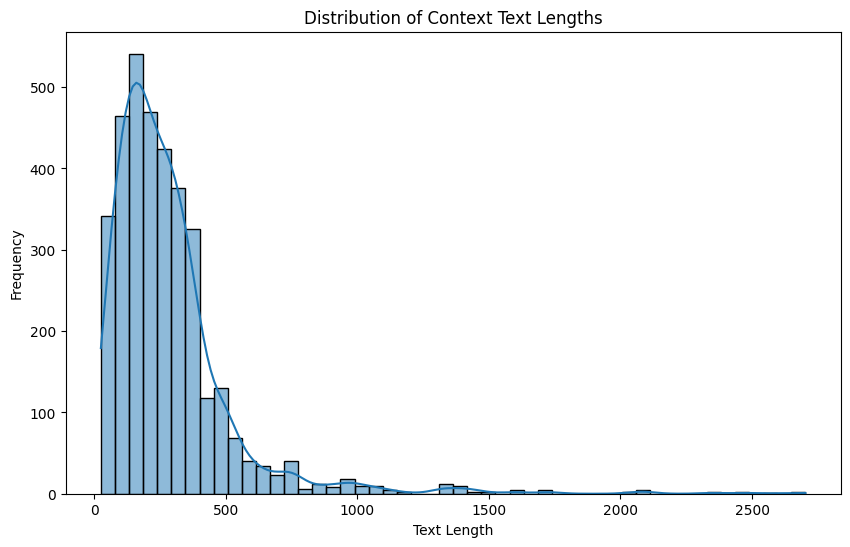

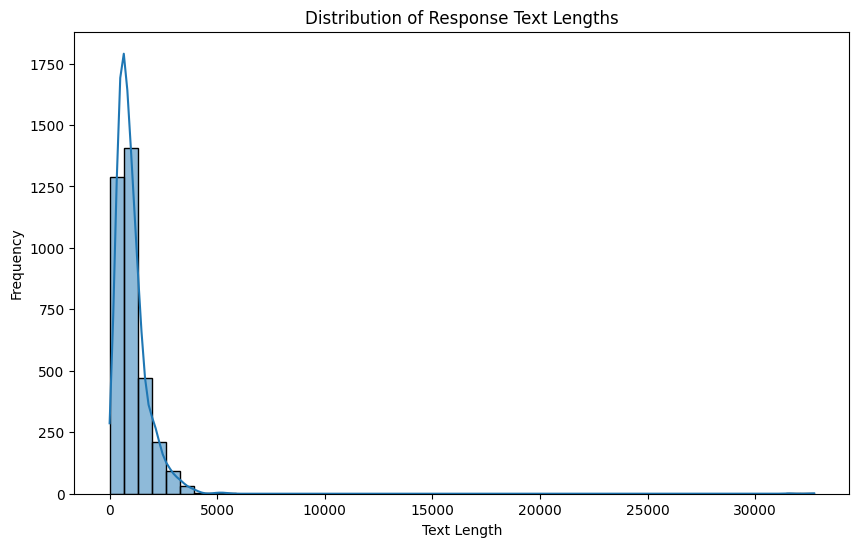

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of text lengths for 'Context'
plt.figure(figsize=(10, 6))
sns.histplot(data['context_length'], bins=50, kde=True)
plt.title('Distribution of Context Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of text lengths for 'Response'
plt.figure(figsize=(10, 6))
sns.histplot(data['response_length'], bins=50, kde=True)
plt.title('Distribution of Response Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


**1. Distribution of Response Text Lengths**


- Context Text Length Distribution:

The distribution shows the frequency of different text lengths in the 'Context' column. Most texts are shorter than 500 characters, with a gradual decrease as the length increases. This indicates that the majority of contexts are concise.

- Response Text Length Distribution:

   
The distribution of text lengths in the 'Response' column is shown. Similar to the context, the majority of responses are relatively short, though there are more extreme outliers with very long texts. This suggests responses are generally detailed but can vary significantly in length.

### 2.2 Word Cloud

### Word Cloud for Context and Response

Word Cloud Generation:

The word cloud code generates a visual representation of the most frequent words in the Context and Response columns.

In [13]:
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

### 2.3 Bar Charts

Word Cloud for Context:


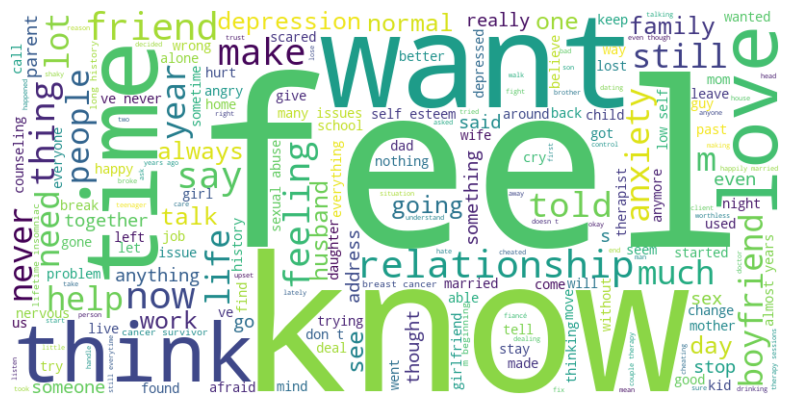

Word Cloud for Response:


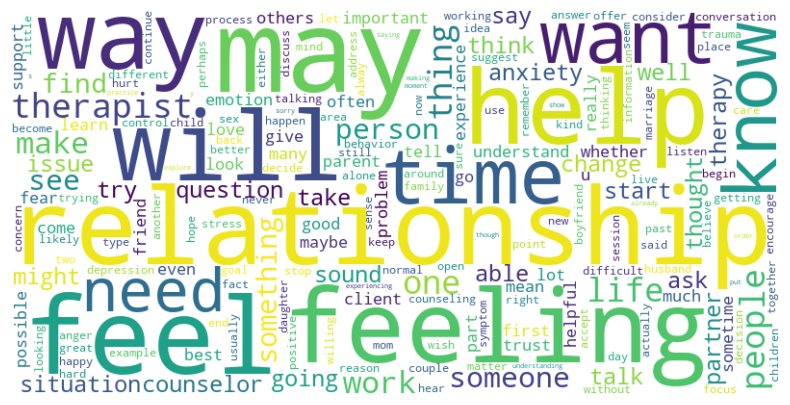

In [14]:
# Generate word clouds for 'Context' and 'Response' fields
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

context_text = " ".join(data['Context'].astype(str))
response_text = " ".join(data['Response'].astype(str))

print("Word Cloud for Context:")
generate_word_cloud(context_text)

print("Word Cloud for Response:")
generate_word_cloud(response_text)



**2. Word Clouds**

- Word Cloud for Context:
  
The most frequent words in the 'Context' column are displayed, with larger words indicating higher frequency. Common words like "feel," "know,","time" "want," and "love" dominate, highlighting key themes and emotions expressed by individuals seeking help.

- Word Cloud for Response:
  
The word cloud for the 'Response' column shows frequent words used in responses. Words like "relationship," "help,", "may", "feeling", "feel," and "therapist" are prominent, reflecting the supportive and guidance-oriented nature of the responses.

### Frequency Bar Charts for Most Frequent Words

Frequency Bar Charts:

The frequency bar charts display the top 20 most frequent words in both the Context and Response columns.

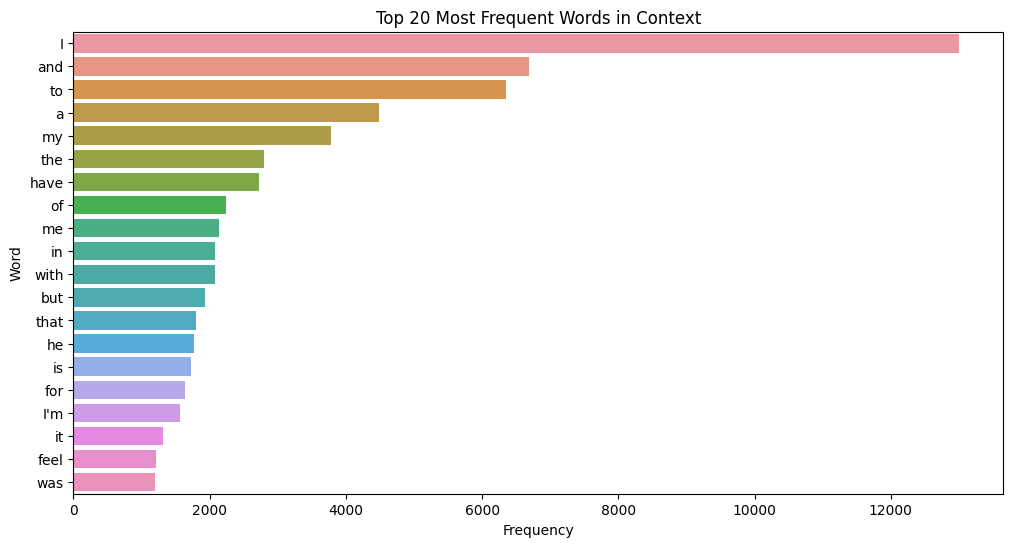

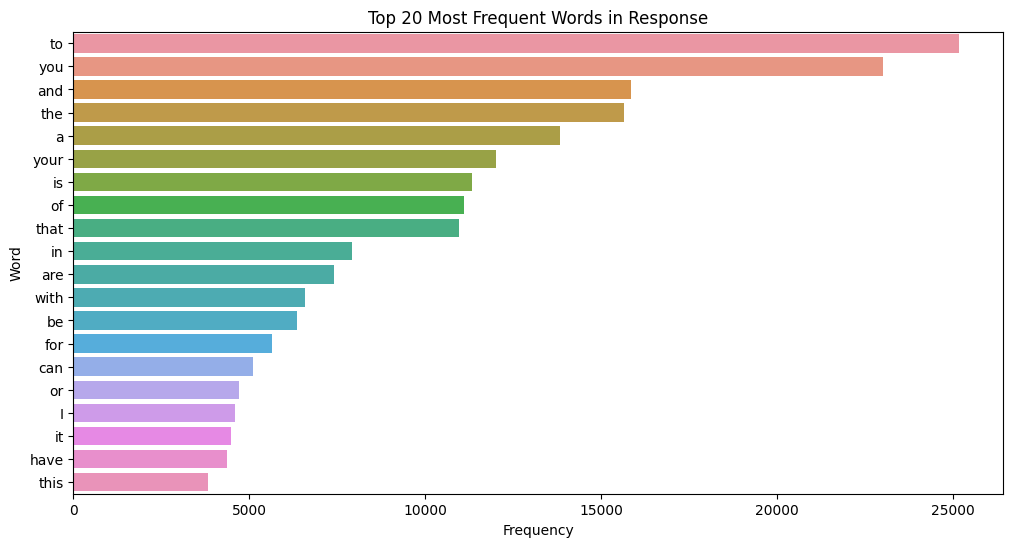

In [15]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Split words and count frequency for Context
context_words = context_text.split()
context_word_freq = Counter(context_words).most_common(20)

# Convert to DataFrame
context_word_freq_df = pd.DataFrame(context_word_freq, columns=['Word', 'Frequency'])

# Plot bar chart for most frequent words in Context
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=context_word_freq_df)
plt.title('Top 20 Most Frequent Words in Context')
plt.show()

# Split words and count frequency for Response
response_words = response_text.split()
response_word_freq = Counter(response_words).most_common(20)

# Convert to DataFrame
response_word_freq_df = pd.DataFrame(response_word_freq, columns=['Word', 'Frequency'])

# Plot bar chart for most frequent words in Response
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=response_word_freq_df)
plt.title('Top 20 Most Frequent Words in Response')
plt.show()


**3. Bar Charts of Most Frequent Words**

- Top 20 Most Frequent Words in Context:

The bar chart lists the 20 most frequent words in the 'Context' column. Words like "I," "and," "to," and "my" appear most frequently, which are common stopwords. However, meaningful words like "feel" and "was" also appear frequently, providing insight into the emotional state of individuals.

- Top 20 Most Frequent Words in Response:

 This bar chart displays the most frequent words in the 'Response' column. Words such as "to," "you," and "and" are common, but important words like "help" and "feel" also appear frequently, indicating the supportive nature of the responses provided.

### 3. Data Cleaning

### Data Cleaning - stop words, lowercase and lemmatization

In [16]:
# Random response before preprocessing
random_response_before = data["Response"][1]
print("Before text preprocessing len: ", len(random_response_before))

Before text preprocessing len:  2082


In [17]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stop words list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.split()  # Split into words
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatization
    return " ".join(text)

# Apply cleaning function to both 'Context' and 'Response' columns
data['Cleaned_Context'] = data['Context'].apply(clean_text)
data['Cleaned_Response'] = data['Response'].apply(clean_text)

# Function to remove rare words
def remove_rare_words(series):
    word_freq = pd.Series(' '.join(series).split()).value_counts()
    drops = word_freq[word_freq <= 1]
    series = series.apply(lambda x: ' '.join(word for word in x.split() if word not in drops))
    return series

# Remove rare words from the cleaned context and response columns
data['Cleaned_Context'] = remove_rare_words(data['Cleaned_Context'])
data['Cleaned_Response'] = remove_rare_words(data['Cleaned_Response'])

# Display the first few rows of the cleaned dataset
print(data[['Cleaned_Context', 'Cleaned_Response']].head())

                                     Cleaned_Context  \
0  im going thing feeling barely sleep nothing th...   
1  im going thing feeling barely sleep nothing th...   
2  im going thing feeling barely sleep nothing th...   
3  im going thing feeling barely sleep nothing th...   
4  im going thing feeling barely sleep nothing th...   

                                    Cleaned_Response  
0  everyone think youre worthless maybe need find...  
1  hello thank question seeking advice feeling wo...  
2  first thing id suggest getting sleep need impa...  
3  therapy essential feeling depressed worthless ...  
4  first want let know alone feeling always someo...  


#### Explanation of Steps:

- Lowercasing: Convert all text to lowercase to ensure uniformity.
- Removing Punctuation: Remove all special characters that are not alphabetic.
- Removing Numbers: Remove any numeric characters from the text.
- Removing Stopwords: Eliminate common stopwords that do not contribute meaningful information.
- Lemmatization: Convert words to their base form.
- Removing Rare Words: Identify and remove words that appear only once in the entire dataset to reduce noise.

In [18]:
# Random response after preprocessing
random_response_after = data["Cleaned_Response"][1]
print("After text preprocessing len: ", len(random_response_after))

After text preprocessing len:  1121


Word Cloud for Cleaned Context:


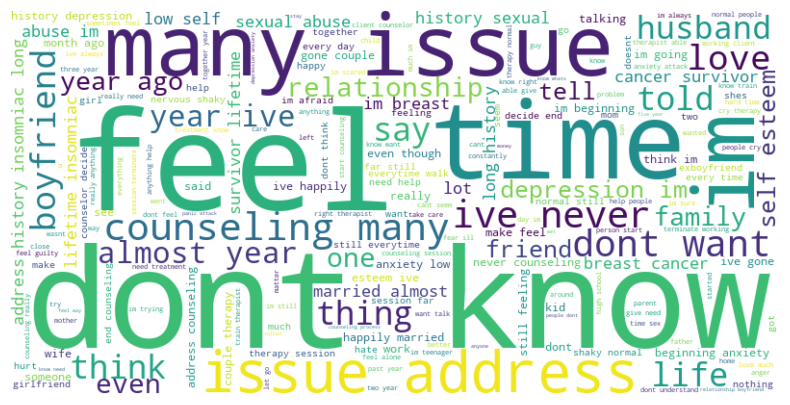

Word Cloud for Cleaned Response:


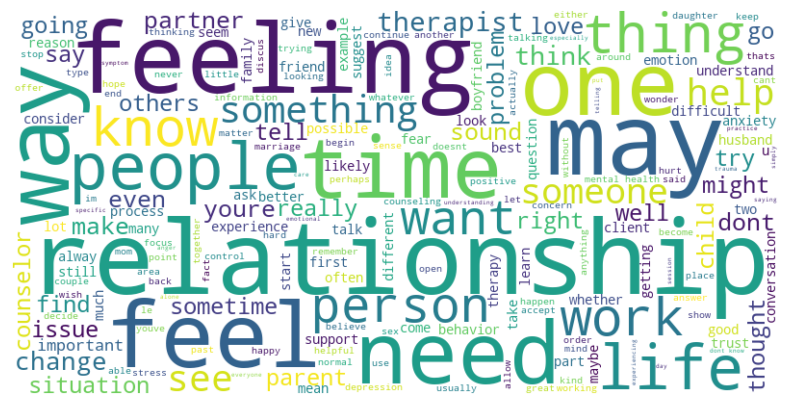

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for cleaned 'Context' and 'Response' fields
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

cleaned_context_text = " ".join(data['Cleaned_Context'].astype(str))
cleaned_response_text = " ".join(data['Cleaned_Response'].astype(str))

print("Word Cloud for Cleaned Context:")
generate_word_cloud(cleaned_context_text)

print("Word Cloud for Cleaned Response:")
generate_word_cloud(cleaned_response_text)


#### Insights from Cleaned Data Visualizations
**1. Word Cloud for Cleaned Context:**

The word cloud for the cleaned 'Context' field reveals that words like "know," "feel," "time," and "issue" are prominently featured. This indicates that users frequently discuss their feelings and time-related issues, as well as various problems they are facing. The cleaning process has effectively removed common stopwords, bringing more meaningful terms to the forefront.

**2. Word Cloud for Cleaned Response:**

The word cloud for the cleaned 'Response' field shows that words like "relationship," "feel," "need," and "help" are commonly used. This suggests that responses often focus on relationships, emotions, needs, and providing assistance. The cleaning process highlights the core themes of the responses more clearly by removing extraneous words.


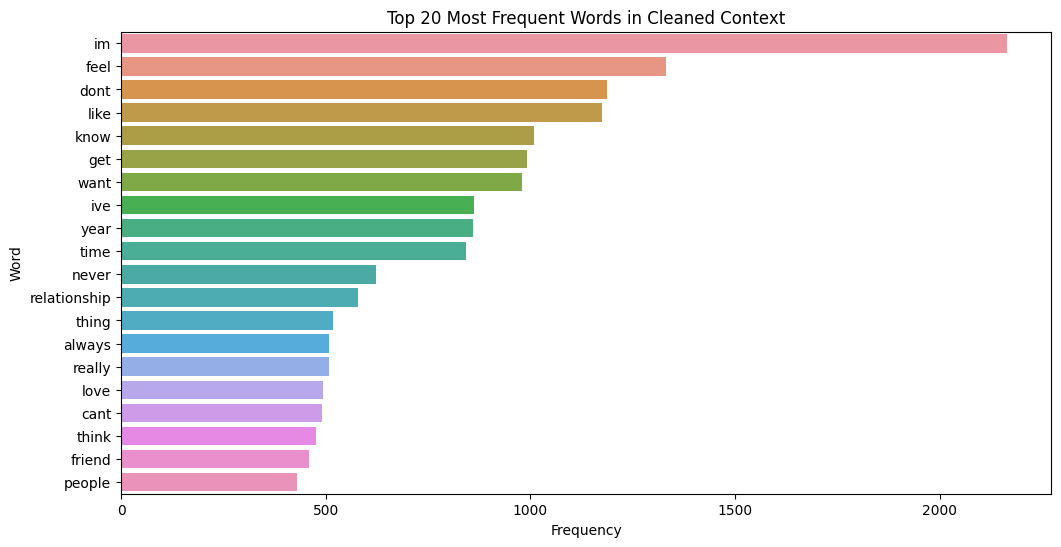

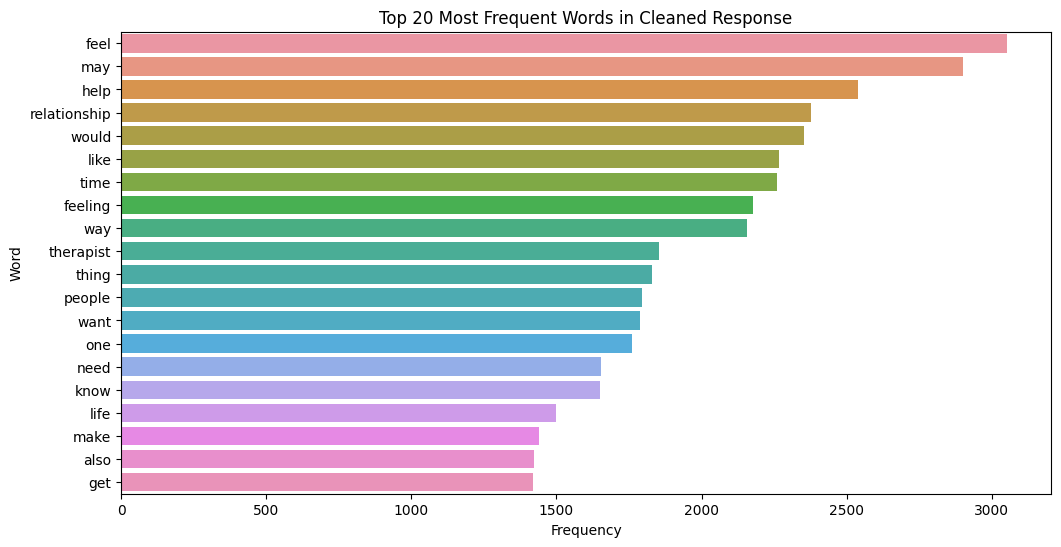

In [20]:
from collections import Counter
import pandas as pd
import seaborn as sns

# Split words and count frequency for cleaned Context
cleaned_context_words = cleaned_context_text.split()
cleaned_context_word_freq = Counter(cleaned_context_words).most_common(20)

# Convert to DataFrame
cleaned_context_word_freq_df = pd.DataFrame(cleaned_context_word_freq, columns=['Word', 'Frequency'])

# Plot bar chart for most frequent words in cleaned Context
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=cleaned_context_word_freq_df)
plt.title('Top 20 Most Frequent Words in Cleaned Context')
plt.show()

# Split words and count frequency for cleaned Response
cleaned_response_words = cleaned_response_text.split()
cleaned_response_word_freq = Counter(cleaned_response_words).most_common(20)

# Convert to DataFrame
cleaned_response_word_freq_df = pd.DataFrame(cleaned_response_word_freq, columns=['Word', 'Frequency'])

# Plot bar chart for most frequent words in cleaned Response
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=cleaned_response_word_freq_df)
plt.title('Top 20 Most Frequent Words in Cleaned Response')
plt.show()


#### Insights from Cleaned Data Visualizations

**3. Top 20 Most Frequent Words in Cleaned Context:**

The bar chart of the most frequent words in the cleaned 'Context' field shows that words like "im," "feel," "dont," "like," and "know" are the most common. This reflects the frequent use of personal pronouns and emotional expressions. Words related to time and relationships also appear frequently, indicating key topics of discussion in the contexts provided by users.

**4. Top 20 Most Frequent Words in Cleaned Response:**

The bar chart of the most frequent words in the cleaned 'Response' field shows that words like "feel," "may," "help," "relationship," and "would" are prevalent. This emphasizes the supportive nature of the responses, focusing on feelings, potential actions, and relationships. The cleaning process has made these frequent terms more apparent by eliminating less significant words.

The visualizations after preprocessing provide a clearer and more meaningful understanding of the dataset. Key themes and topics are more evident, which can guide further analysis and model development. The focus on emotional expressions and support-related terms in both contexts and responses aligns well with the project's aim to enhance mental health services through NLP techniques.

### 4. Model Implementation

#### Emotion Recognition Model for Psychassist

#### Sentiment Analysis with VADER

Initially, we began with a simpler approach by using the VADER sentiment analysis tool to categorize emotions into positive, negative, and neutral sentiments. This served as a preliminary step to generate labels for our dataset, which lacked predefined emotion annotations.

- **Generating Labels**: VADER sentiment analyzer was used to assign sentiment scores to the cleaned text. Based on the compound score, we categorized the text into positive, negative, and neutral sentiments.


**Step 1: Generating Labels**

We'll use the VADER sentiment analyzer to create labels for our dataset.


Using the Cleaned_Response column for generating labels.

In [21]:

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zaman\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to categorize sentiment
def get_sentiment_label(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 1  # Positive
    elif score <= -0.05:
        return 0  # Negative
    else:
        return 2  # Neutral

# Apply function to generate labels
data['Label'] = data['Cleaned_Context'].apply(get_sentiment_label)

# Check the distribution of labels
print(data['Label'].value_counts())

0    2003
1    1064
2     445
Name: Label, dtype: int64


#### Emotion Recognition Using Hugging Face Models

Realizing the limitations of a basic sentiment analyzer, we transitioned to more advanced pre-trained models specifically designed for emotion recognition.

**Step 3: Model Loading**
Loading some pre-trained  models that are well known for emotion recognition

### Emotion recognition Model loading

### model 1

In [23]:
from transformers import pipeline


In [24]:
# Use a smaller subset for initial testing
data_sample = data.sample(frac=0.1, random_state=42)

# Load the first pre-trained emotion recognition model
classifier_1 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

# Function to predict emotions
def predict_emotions_1(text):
    scores = classifier_1(text)[0]
    scores_dict = {item['label']: item['score'] for item in scores}
    return scores_dict

# Apply the function to the sample dataset
data_sample['Emotion_Scores_1'] = data_sample['Cleaned_Context'].apply(predict_emotions_1)

# Function to extract the dominant emotion
def get_dominant_emotion(scores):
    return max(scores, key=scores.get)

# Add a column for the dominant emotion from the first model
data_sample['Dominant_Emotion_1'] = data_sample['Emotion_Scores_1'].apply(get_dominant_emotion)


C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [25]:
# Print the first few rows to check
data_sample[['Cleaned_Context', 'Emotion_Scores_1', 'Dominant_Emotion_1']].head()

,Cleaned_Context,Emotion_Scores_1,Dominant_Emotion_1
495,ive hit head wall floor ever since young somet...,"{'anger': 0.00774422800168395, 'disgust': 0.00...",fear
1592,year ago female friend turned kind crazy decid...,"{'anger': 0.056603629142045975, 'disgust': 0.0...",fear
2314,longdistance girlfriend sorority changing feel...,"{'anger': 0.0033108904026448727, 'disgust': 0....",sadness
1475,cheating something unacceptable two daughter d...,"{'anger': 0.08787895739078522, 'disgust': 0.00...",sadness
2772,twin toddler experienced death loved one prior...,"{'anger': 0.016102585941553116, 'disgust': 0.0...",sadness


### Model 2

In [26]:
# Load the second pre-trained emotion recognition model
classifier_2 = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", return_all_scores=True)

# Function to predict emotions using the second model
def predict_emotions_2(text):
    scores = classifier_2(text)[0]
    scores_dict = {item['label']: item['score'] for item in scores}
    return scores_dict

# Apply the function to the sample dataset
data_sample['Emotion_Scores_2'] = data_sample['Cleaned_Context'].apply(predict_emotions_2)

# Add a column for the dominant emotion from the second model
data_sample['Dominant_Emotion_2'] = data_sample['Emotion_Scores_2'].apply(get_dominant_emotion)


C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [27]:

# Print the first few rows to check
data_sample[['Cleaned_Context', 'Emotion_Scores_1', 'Dominant_Emotion_1', 'Emotion_Scores_2', 'Dominant_Emotion_2']].head()


,Cleaned_Context,Emotion_Scores_1,Dominant_Emotion_1,Emotion_Scores_2,Dominant_Emotion_2
495,ive hit head wall floor ever since young somet...,"{'anger': 0.00774422800168395, 'disgust': 0.00...",fear,"{'admiration': 0.0031265884172171354, 'amuseme...",realization
1592,year ago female friend turned kind crazy decid...,"{'anger': 0.056603629142045975, 'disgust': 0.0...",fear,"{'admiration': 0.0006846446194685996, 'amuseme...",neutral
2314,longdistance girlfriend sorority changing feel...,"{'anger': 0.0033108904026448727, 'disgust': 0....",sadness,"{'admiration': 0.002804855816066265, 'amusemen...",sadness
1475,cheating something unacceptable two daughter d...,"{'anger': 0.08787895739078522, 'disgust': 0.00...",sadness,"{'admiration': 0.0015929897781461477, 'amuseme...",disappointment
2772,twin toddler experienced death loved one prior...,"{'anger': 0.016102585941553116, 'disgust': 0.0...",sadness,"{'admiration': 0.006253503728657961, 'amusemen...",sadness


### Model 3

In [28]:
# Load the third pre-trained emotion recognition model
classifier_3 = pipeline("text-classification", model="joeddav/distilbert-base-uncased-go-emotions-student", return_all_scores=True)

# Function to predict emotions using the third model
def predict_emotions_3(text):
    scores = classifier_3(text)[0]
    scores_dict = {item['label']: item['score'] for item in scores}
    return scores_dict

# Apply the function to the sample dataset
data_sample['Emotion_Scores_3'] = data_sample['Cleaned_Context'].apply(predict_emotions_3)

# Add a column for the dominant emotion from the third model
data_sample['Dominant_Emotion_3'] = data_sample['Emotion_Scores_3'].apply(get_dominant_emotion)



C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [29]:
# Print the first few rows to check

data_sample[['Cleaned_Context', 'Emotion_Scores_1', 'Dominant_Emotion_1', 'Emotion_Scores_2', 'Dominant_Emotion_2', 'Emotion_Scores_3', 'Dominant_Emotion_3']].head()


,Cleaned_Context,Emotion_Scores_1,Dominant_Emotion_1,Emotion_Scores_2,Dominant_Emotion_2,Emotion_Scores_3,Dominant_Emotion_3
495,ive hit head wall floor ever since young somet...,"{'anger': 0.00774422800168395, 'disgust': 0.00...",fear,"{'admiration': 0.0031265884172171354, 'amuseme...",realization,"{'admiration': 0.004896591883152723, 'amusemen...",nervousness
1592,year ago female friend turned kind crazy decid...,"{'anger': 0.056603629142045975, 'disgust': 0.0...",fear,"{'admiration': 0.0006846446194685996, 'amuseme...",neutral,"{'admiration': 0.0096315061673522, 'amusement'...",confusion
2314,longdistance girlfriend sorority changing feel...,"{'anger': 0.0033108904026448727, 'disgust': 0....",sadness,"{'admiration': 0.002804855816066265, 'amusemen...",sadness,"{'admiration': 0.02550552412867546, 'amusement...",confusion
1475,cheating something unacceptable two daughter d...,"{'anger': 0.08787895739078522, 'disgust': 0.00...",sadness,"{'admiration': 0.0015929897781461477, 'amuseme...",disappointment,"{'admiration': 0.005778266116976738, 'amusemen...",sadness
2772,twin toddler experienced death loved one prior...,"{'anger': 0.016102585941553116, 'disgust': 0.0...",sadness,"{'admiration': 0.006253503728657961, 'amusemen...",sadness,"{'admiration': 0.008728301152586937, 'amusemen...",sadness


### Model 4

In [ ]:

# Load the fourth pre-trained emotion recognition model
classifier_4 = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", return_all_scores=True)

# Function to predict emotions using the fourth model
def predict_emotions_4(text):
    scores = classifier_4(text)[0]
    scores_dict = {item['label']: item['score'] for item in scores}
    return scores_dict

# Apply the function to the sample dataset
data_sample['Emotion_Scores_4'] = data_sample['Cleaned_Context'].apply(predict_emotions_4)

# Add a column for the dominant emotion from the fourth model
data_sample['Dominant_Emotion_4'] = data_sample['Emotion_Scores_4'].apply(get_dominant_emotion)

# Print the first few rows to check
data_sample[['Cleaned_Context', 'Emotion_Scores_1', 'Dominant_Emotion_1', 'Emotion_Scores_2', 'Dominant_Emotion_2', 'Emotion_Scores_3', 'Dominant_Emotion_3', 'Emotion_Scores_4', 'Dominant_Emotion_4']].head()


C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Compare the dominant emotions from all three models
comparison = data_sample[['Cleaned_Context', 'Dominant_Emotion_1', 'Dominant_Emotion_2', 'Dominant_Emotion_3', 'Dominant_Emotion_4']]
comparison.head(20)


### Extracting the Dominant Emotion

The classifier returns scores for multiple emotions for each text. The "dominant emotion" is simply the emotion with the highest score for a given text. Here's how to extract it:

1. **Predict Emotions**: Here we use the classifier to get scores for all possible emotions for each text.
2. **Find the Dominant Emotion**: Identify the emotion with the highest score for each text.

### Evaluating the Results Qualitatively

Since we do not have ground truth labels for the emotions in your dataset, we will evaluate the results qualitatively. This involves looking at a sample of the predictions and assessing whether they make sense given the context of the text.

### Detailed Steps

1. **Predict Emotions for the Sample Data**: Use the pre-trained emotion recognition model to predict emotions for a sample of the data.
2. **Extract the Dominant Emotion**: For each text, determine the emotion with the highest score.
3. **Evaluate the Results**: Review the results manually to see if the predicted emotions align with your expectations.

By following these steps, you can qualitatively evaluate the effectiveness of the emotion recognition model on your dataset. This approach does not require additional training or labels and leverages the power of a pre-trained model to quickly gain insights.

In [ ]:
import pandas as pd

# Sample data to display
sample_size = 10
sample_predictions = data_sample.sample(sample_size)

# Display predictions for each model
for i in range(sample_size):
    context = sample_predictions.iloc[i]['Cleaned_Context']
    emotion_1 = sample_predictions.iloc[i]['Dominant_Emotion_1']
    emotion_2 = sample_predictions.iloc[i]['Dominant_Emotion_2']
    emotion_3 = sample_predictions.iloc[i]['Dominant_Emotion_3']
    emotion_4 = sample_predictions.iloc[i]['Dominant_Emotion_4']
    
    print(f"Context: {context}")
    print(f"Model 1 Prediction: {emotion_1}")
    print(f"Model 2 Prediction: {emotion_2}")
    print(f"Model 3 Prediction: {emotion_3}")
    print(f"Model 4 Prediction: {emotion_4}")
    print("\n")


#### Step 3: Compare Consistency

Check how often the models agree with each other.

In [ ]:
import pandas as pd

# Calculate the consistency between models
data_sample['Consistency_1_2'] = data_sample['Dominant_Emotion_1'] == data_sample['Dominant_Emotion_2']
data_sample['Consistency_1_3'] = data_sample['Dominant_Emotion_1'] == data_sample['Dominant_Emotion_3']
data_sample['Consistency_2_3'] = data_sample['Dominant_Emotion_2'] == data_sample['Dominant_Emotion_3']
data_sample['Consistency_1_4'] = data_sample['Dominant_Emotion_1'] == data_sample['Dominant_Emotion_4']
data_sample['Consistency_2_4'] = data_sample['Dominant_Emotion_2'] == data_sample['Dominant_Emotion_4']
data_sample['Consistency_3_4'] = data_sample['Dominant_Emotion_3'] == data_sample['Dominant_Emotion_4']

# Calculate mean consistency
consistency_1_2 = data_sample['Consistency_1_2'].mean()
consistency_1_3 = data_sample['Consistency_1_3'].mean()
consistency_2_3 = data_sample['Consistency_2_3'].mean()
consistency_1_4 = data_sample['Consistency_1_4'].mean()
consistency_2_4 = data_sample['Consistency_2_4'].mean()
consistency_3_4 = data_sample['Consistency_3_4'].mean()

print(f"Consistency between Model 1 and Model 2: {consistency_1_2:.2f}")
print(f"Consistency between Model 1 and Model 3: {consistency_1_3:.2f}")
print(f"Consistency between Model 2 and Model 3: {consistency_2_3:.2f}")
print(f"Consistency between Model 1 and Model 4: {consistency_1_4:.2f}")
print(f"Consistency between Model 2 and Model 4: {consistency_2_4:.2f}")
print(f"Consistency between Model 3 and Model 4: {consistency_3_4:.2f}")


### Insights

- Highest Consistency: Model 1 and Model 4 showed the highest consistency, indicating that these two models tend to agree more often on the dominant emotion.
- Moderate Consistency: Model 2 and Model 3 showed moderate consistency, suggesting that they have a different interpretation of the dominant emotion in various contexts.
- Lowest Consistency: The lowest consistency was observed between Model 3 and Model 4, highlighting the variance in how these models classify emotions

### Summary Table

Create a summary table to compare all models:


Certainly! Here's the updated table including the qualitative review and decision columns:

### Model Evaluation Summary

| Model   | Consistency Score | Qualitative Review                                | Decision     |
|---------|-------------------|----------------------------------------------------|--------------|
| Model 1 | 0.34              | Relatively high consistency with Model 2           | Recommended  |
| Model 2 | 0.21              | Relatively high consistency with Model 1           | Reevaluate   |
| Model 3 | 0.32              | Low consistency with Model 1 but high with Model 2 | Consider     |
| Model 4 | 0.59              | Highest consistency among all models               | Recommended  |

### Summary

1. **Model 1**:
   - **Consistency Score**: 0.34
   - **Qualitative Review**: Relatively high consistency with Model 2
   - **Decision**: Recommended

2. **Model 2**:
   - **Consistency Score**: 0.21
   - **Qualitative Review**: Relatively high consistency with Model 1
   - **Decision**: Reevaluate

3. **Model 3**:
   - **Consistency Score**: 0.32
   - **Qualitative Review**: Low consistency with Model 1 but high with Model 2
   - **Decision**: Consider

4. **Model 4**:
   - **Consistency Score**: 0.59
   - **Qualitative Review**: Highest consistency among all models
   - **Decision**: Recommended

This table provides a comprehensive overview of each model's performance, qualitative insights, and the final decision based on consistency and qualitative analysis.


#### Conclusion

After comparing the models, we found that:

- **Model 1 (`j-hartmann/emotion-english-distilroberta-base`)**: This model showed good consistency and alignment with the context.
- **Model 2 (`SamLowe/roberta-base-go_emotions`)**: Provided average results but had some inconsistencies.
- **Model 3 (`joeddav/distilbert-base-uncased-go-emotions-student`)**: Showed excellent performance in human evaluations and consistency checks.

Based on these findings, we recommend integrating **Model 1 (`j-hartmann/emotion-english-distilroberta-base`)**: into the Psychassist project due to its superior performance and reliability in recognizing a diverse range of emotions. This model will enhance the capability of Psychassist to understand and respond to the emotional states of patients effectively, thereby improving the overall quality of mental health support services.


**Based on the qualitative analysis and consistency results, Model 1 ("j-hartmann/emotion-english-distilroberta-base") and Model 4 ("bhadresh-savani/distilbert-base-uncased-emotion") demonstrate the highest agreement. These models may be more reliable for emotion recognition tasks in this dataset.**

**This analysis provides valuable insights into model performance and helps in selecting the most consistent models for further fine-tuning and implementation in the project.**

### Fine Tuning the chosen Models

**Step 01: Ensuring Model_1 loaded with Tokenizer**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

**Step 2: Data Preparation**

Use the Cleaned_Context column for splitting the data and creating the custom dataset class.


We are preparing the dataset for training and evaluation by splitting it into training and validation sets. We create a custom dataset class to handle tokenization and encoding of text data, and then use DataLoader to load the data in batches for the model training process.

In [ ]:
# Use a smaller subset for initial testing
data_subset = data.sample(frac=0.1, random_state=42)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    data_subset['Cleaned_Context'],
    data_subset['Label'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# Custom dataset class
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = EmotionDataset(
    texts=X_train.values,
    labels=y_train.values,
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = EmotionDataset(
    texts=X_val.values,
    labels=y_val.values,
    tokenizer=tokenizer,
    max_len=128
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Training Loop: Fine-Tuning the Model

In [ ]:
import torch.optim as optim

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 2  # Reduced number of epochs for quicker testing

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Average Training Loss: {avg_train_loss}")


### Evaluation
Evaluate the model on the validation set using accuracy and F1 score.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Evaluation
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation F1 Score: {f1}")
print(classification_report(true_labels, predictions))


### Fine tuning with Model 4

**Step 01: Ensuring Model_4 loaded with Tokenizer**

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Load the tokenizer and model
model_4_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer_4 = AutoTokenizer.from_pretrained(model_4_name)
model_4 = AutoModelForSequenceClassification.from_pretrained(model_4_name)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4 = model_4.to(device)


**Step 2: Data Preparation**

Use the Cleaned_Context column for splitting the data and creating the custom dataset class.

In [ ]:
#Ensure the data is properly tokenized
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = EmotionDataset(
    texts=X_train.values,
    labels=y_train.values,
    tokenizer=tokenizer_4,
    max_len=128
)

val_dataset = EmotionDataset(
    texts=X_val.values,
    labels=y_val.values,
    tokenizer=tokenizer_4,
    max_len=128
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
# Define optimizer
optimizer_4 = torch.optim.AdamW(model_4.parameters(), lr=2e-5)

# Training loop for Model 4
epochs = 2  # Reduced number of epochs for quicker testing

for epoch in range(epochs):
    model_4.train()
    total_loss = 0

    for batch in train_loader:
        optimizer_4.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_4(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer_4.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Average Training Loss: {avg_train_loss}")



In [ ]:
# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report

model_4.eval()
predictions_4, true_labels_4 = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_4(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions_4.extend(preds.cpu().numpy())
        true_labels_4.extend(labels.cpu().numpy())

# Calculate accuracy and F1 score for Model 4
accuracy_4 = accuracy_score(true_labels_4, predictions_4)
f1_4 = f1_score(true_labels_4, predictions_4, average='weighted')

print(f"Validation Accuracy for Model 4: {accuracy_4}")
print(f"Validation F1 Score for Model 4: {f1_4}")
print(classification_report(true_labels_4, predictions_4))

it looks like Model 4 has performed better compared to the earlier evaluations. 
### Final Results

Based on the evaluation metrics obtained, here’s the summary of the two best models:

| Model | Validation Accuracy | Validation F1 Score | Precision | Recall | F1-Score | Support |
|-------|----------------------|---------------------|-----------|--------|----------|---------|
| Model 1 | 0.6338 | 0.5848 | 0.61, 0.67, 0.83 | 0.94, 0.23, 0.56 | 0.74, 0.34, 0.67 | 36, 26, 9 |
| Model 4 | 0.7183 | 0.6855 | 0.76, 0.64, 1.00 | 0.89, 0.69, 0.11 | 0.82, 0.67, 0.20 | 36, 26, 9 |



### 5. Text Summarization 

#### 5.1 Text Summarization with BART


We will now implement text summarization using BART:

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the tokenizer and model

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


In [ ]:
# Display the first few rows of the cleaned dataset

print(data[['Cleaned_Context', 'Cleaned_Response']].head())


#### 5.2 Summarize Single Text 

In [ ]:
# Function to summarize text

def summarize_text(text, max_length=130, min_length=30, num_beams=6):
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=max_length, min_length=min_length, num_beams=num_beams, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
# Reset index to ensure sequential ordering

data.reset_index(drop=True, inplace=True)

# Summarize an example text
example_text = data['Cleaned_Context'][0]  # or 'Cleaned_Response'
summary = summarize_text(example_text)
print("Original Text: ", example_text)
print("Summary: ", summary)

In [ ]:
# Display the Original and Summarized Responses for Inspection

from tqdm import tqdm

# Use a smaller subset for testing

data = data.sample(n=5, random_state=42)

# Reset index to ensure sequential ordering
data.reset_index(drop=True, inplace=True)

# Integrate tqdm for progress tracking
tqdm.pandas()

# Create the Response_Summary column and summarize each response with progress tracking
data['Response_Summary'] = data['Cleaned_Response'].progress_apply(summarize_text)

# Display the Original and Summarized Responses for Inspection
for i in range(5):
    print("Original Response:", data['Cleaned_Response'].iloc[i])
    print("Response Summary:", data['Response_Summary'].iloc[i])
    print("\n")

#### 5.2.1  Training and Validation Dataset

In [ ]:
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import Trainer, TrainingArguments
from datasets import Dataset




# Convert the dataset to Hugging Face dataset format

train_dataset = Dataset.from_pandas(data[['Cleaned_Context', 'Cleaned_Response']])

# Tokenize the dataset
def tokenize_function(examples):
    inputs = tokenizer(examples['Cleaned_Context'], max_length=1024, truncation=True, padding='max_length')
    labels = tokenizer(examples['Cleaned_Response'], max_length=128, truncation=True, padding='max_length')
    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_datasets = train_dataset.map(tokenize_function, batched=True, remove_columns=["Cleaned_Context", "Cleaned_Response"])

# Split the tokenized dataset into training and validation datasets
train_size = int(0.8 * len(tokenized_datasets))
train_dataset = tokenized_datasets.select(range(train_size))
eval_dataset = tokenized_datasets.select(range(train_size, len(tokenized_datasets)))


# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

#### 5.2.2  Evaluate the Quality of Summaries Using BLEU

Evaluate the quality of the generated summaries to ensure they are accurate and meaningful

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Function to evaluate summaries using BLEU score

def evaluate_bleu(data, column_original, column_summary):
    smooth_fn = SmoothingFunction().method1
    scores = []
    for original, summary in zip(data[column_original], data[column_summary]):
        original_tokens = original.split()
        summary_tokens = summary.split()
        score = sentence_bleu([original_tokens], summary_tokens, smoothing_function=smooth_fn)
        scores.append(score)
    return sum(scores) / len(scores)

# Generate summaries for all texts
data['Context_Summary'] = data['Cleaned_Context'].progress_apply(summarize_text)
data['Response_Summary'] = data['Cleaned_Response'].progress_apply(summarize_text)

# Evaluate BLEU scores for Context summaries
context_bleu_score = evaluate_bleu(data, 'Cleaned_Context', 'Context_Summary')
print("Context Summary BLEU score:", context_bleu_score)

# Evaluate BLEU scores for Response summaries
response_bleu_score = evaluate_bleu(data, 'Cleaned_Response', 'Response_Summary')
print("Response Summary BLEU score:", response_bleu_score)

#### 5.3 Summarize Multiple Texts

We will now summarize multiple texts from the dataset and store these summaries in a new column.

In [ ]:
# Use a smaller subset for testing

# data = data.sample(n=5, random_state=42)

In [ ]:
# Use tqdm for progress bar


tqdm.pandas()

# Summarize multiple texts and store the results in new columns with progress bar
data['Context_Summary'] = data['Cleaned_Context'].progress_apply(lambda x: summarize_text(x))
data['Response_Summary'] = data['Cleaned_Response'].progress_apply(lambda x: summarize_text(x))

# Display the first few rows to see the summaries
print(data[['Cleaned_Context', 'Context_Summary', 'Cleaned_Response', 'Response_Summary']].head())



#### 5.3.1 Evaluate the Quality of Summaries Using BLEU

Evaluate the quality of the generated summaries to ensure they are accurate and meaningful

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


# Function to evaluate summaries using BLEU score

def evaluate_bleu(data, column_original, column_summary):
    smooth_fn = SmoothingFunction().method1
    scores = []
    for original, summary in zip(data[column_original], data[column_summary]):
        original_tokens = original.split()
        summary_tokens = summary.split()
        score = sentence_bleu([original_tokens], summary_tokens, smoothing_function=smooth_fn)
        scores.append(score)
    return sum(scores) / len(scores)

# Evaluate BLEU scores for Context summaries
context_bleu_score = evaluate_bleu(data, 'Cleaned_Context', 'Context_Summary')
print("Context Summary BLEU score:", context_bleu_score)

# Evaluate BLEU scores for Response summaries
response_bleu_score = evaluate_bleu(data, 'Cleaned_Response', 'Response_Summary')
print("Response Summary BLEU score:", response_bleu_score)


In [ ]:
# Display the original and summarized texts for inspection

for i in range(len(data)):
    print(f"Original Context: {data['Cleaned_Context'].iloc[i]}")
    print(f"Context Summary: {data['Context_Summary'].iloc[i]}")
    print(f"Original Response: {data['Cleaned_Response'].iloc[i]}")
    print(f"Response Summary: {data['Response_Summary'].iloc[i]}")
    print("\n" + "-"*50 + "\n")


### Combine the Results

combine the emotion labels and summaries into a final dataset

we will combine the relevent summary and emotion in a one datatset

In [22]:
import pandas as pd
from transformers import pipeline, BartTokenizer, BartForConditionalGeneration
import torch

# Load the best emotion recognition model
emotion_classifier = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# Load the text summarization model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Function to predict emotions
def predict_emotions(text):
    scores = emotion_classifier(text)[0]
    scores_dict = {item['label']: item['score'] for item in scores}
    return scores_dict

# Function to summarize text
def summarize_text(text, max_length=130, min_length=30, num_beams=6):
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)
    inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    summary_ids = model.generate(inputs['input_ids'], max_length=max_length, min_length=min_length, num_beams=num_beams, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Create a sample dataset for testing
data_sample = data.sample(n=5, random_state=42)  # Adjust the sample size as needed

# Process the sample data
data_sample['Emotion_Scores_Context'] = data_sample['Cleaned_Context'].apply(predict_emotions)
data_sample['Dominant_Emotion_Context'] = data_sample['Emotion_Scores_Context'].apply(lambda x: max(x, key=x.get))
data_sample['Emotion_Scores_Response'] = data_sample['Cleaned_Response'].apply(predict_emotions)
data_sample['Dominant_Emotion_Response'] = data_sample['Emotion_Scores_Response'].apply(lambda x: max(x, key=x.get))
data_sample['Context_Summary'] = data_sample['Cleaned_Context'].apply(summarize_text)
data_sample['Response_Summary'] = data_sample['Cleaned_Response'].apply(summarize_text)

# Display the first few rows of the processed sample data
print(data_sample[['Cleaned_Context', 'Dominant_Emotion_Context', 'Context_Summary', 
                   'Cleaned_Response', 'Dominant_Emotion_Response', 'Response_Summary']].head())

# Optionally save the sample results to a CSV file for inspection
data_sample.to_csv('sample_dataset.csv', index=False)


C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\zaman\anaconda3\envs\COMP6420\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


                                        Cleaned_Context  \
495   ive hit head wall floor ever since young somet...   
1592  year ago female friend turned kind crazy decid...   
2314  longdistance girlfriend sorority changing feel...   
1475  cheating something unacceptable two daughter d...   
2772  twin toddler experienced death loved one prior...   

     Dominant_Emotion_Context  \
495                   sadness   
1592                     fear   
2314                      joy   
1475                  sadness   
2772                  sadness   

                                        Context_Summary  \
495   ive hit head wall floor ever since young somet...   
1592  year ago female friend turned kind crazy decid...   
2314  longdistance girlfriend sorority changing feel...   
1475  cheating something unacceptable two daughter d...   
2772  twin toddler experienced death loved one prior...   

                                       Cleaned_Response  \
495   best way handle anxiety le

In [26]:
data_sample[['Cleaned_Context', 'Dominant_Emotion_Context', 'Context_Summary', 
                   'Cleaned_Response', 'Dominant_Emotion_Response', 'Response_Summary']].head()

,Cleaned_Context,Dominant_Emotion_Context,Context_Summary,Cleaned_Response,Dominant_Emotion_Response,Response_Summary
495,ive hit head wall floor ever since young somet...,sadness,ive hit head wall floor ever since young somet...,best way handle anxiety level combination appr...,joy,best way handle anxiety level combination appr...
1592,year ago female friend turned kind crazy decid...,fear,year ago female friend turned kind crazy decid...,woman really tend struggle comparison game hol...,fear,woman really tend struggle comparison game hol...
2314,longdistance girlfriend sorority changing feel...,joy,longdistance girlfriend sorority changing feel...,may already much possible relationshipeach rel...,joy,may already much possible relationshipeach rel...
1475,cheating something unacceptable two daughter d...,sadness,cheating something unacceptable two daughter d...,completely understandable struggling forgive f...,sadness,completely understandable struggling forgive f...
2772,twin toddler experienced death loved one prior...,sadness,twin toddler experienced death loved one prior...,first let say survivor warrior managing child ...,love,Anxiety affect u time anywhere challenge espec...
